In [20]:
import pandas as pd

from src.SemEvalData import SemEvalData
from src.JigsawData import JigsawData
from nltk import tokenize
import nltk
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout, Flatten
from keras import backend as K
from keras import optimizers
from keras.models import Model
from src.Attention import Attention
import re
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
from src.preprocessing import get_embeddings_index, get_embeddings_matrix, getSpansByToxicWords
from keras import Sequential

In [21]:
##set to .env
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_WORD_NUM = 40     # maximum number of letters in sentence?
EMBED_SIZE = 50  ## same value as in dimension of glove
VAL_SPLIT = 0.2  
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [22]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
## load data
train_data_semeval = SemEvalData(MAX_WORD_NUM)
train_data_semeval.load_data("data/tsd_trial.csv")
train_df_preprocessed = train_data_semeval.preprocess()

In [27]:
extra_train = JigsawData(MAX_WORD_NUM)
extra_train.load_data("data/train.csv")
extra_df_preprocessed = extra_train.preprocess()

In [28]:
print(train_df_preprocessed)
print(train_data_semeval.get_classes_amount(train_df_preprocessed))
##add data 
additional_data = extra_train.get_missing_class_elements(extra_df_preprocessed, 100, 0.0)
print(additional_data)
frames = [train_df_preprocessed, additional_data]
train_df_preprocessed = pd.concat(frames)
# train_df_preprocessed
print(train_data_semeval.get_classes_amount(train_df_preprocessed))

                                                 spans  \
0             [15, 16, 17, 18, 19, 27, 28, 29, 30, 31]   
1                             [29, 30, 31, 32, 33, 34]   
2                       [166, 167, 168, 169, 170, 171]   
3                             [87, 88, 89, 90, 91, 92]   
4                                                   []   
..                                                 ...   
685                     [129, 130, 131, 132, 133, 134]   
686                     [126, 127, 128, 129, 130, 131]   
687                           [24, 25, 26, 27, 28, 29]   
688  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
689                     [136, 137, 138, 139, 140, 141]   

                                                  text  toxicity  \
0    because hes a moron and a bigot. its not any m...         1   
1    how about we stop protecting idiots and let na...         1   
2    if people  were  smart, they would  boycott th...         1   
3    trump claimed that russia 

In [29]:
train_df_preprocessed

,spans,text,toxicity,toxic_words,original_text,sentences,toxicity_sentence
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",because hes a moron and a bigot. its not any m...,1.0,"[moron, bigot]",Because he's a moron and a bigot. It's not any...,"[because hes a moron and a bigot., its not any...","[1.0, 0.0]"
1,"[29, 30, 31, 32, 33, 34]",how about we stop protecting idiots and let na...,1.0,[idiots],How about we stop protecting idiots and let na...,[how about we stop protecting idiots and let n...,"[1.0, 0.0]"
2,"[166, 167, 168, 169, 170, 171]","if people were smart, they would boycott th...",1.0,[idiots],"If people were smart, they would Boycott th...","[if people were smart, they would boycott t...",[1.0]
3,"[87, 88, 89, 90, 91, 92]",trump claimed that russia will never invade th...,1.0,[stupid],Trump Claimed that Russia will never invade th...,[trump claimed that russia will never invade t...,[1.0]
4,[],as long as your willing to pay a lot more for ...,0.0,[],As long as your willing to pay a lot more for ...,[as long as your willing to pay a lot more for...,"[0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...
24254,NaN,let us examine what is considered black in the...,0.0,NaN,NaN,[let us examine what is considered black in th...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
123640,NaN,3rr i think you broke 3rr on depleted uraniu...,0.0,NaN,NaN,[3rr i think you broke 3rr on depleted urani...,"[0.0, 0.0]"
111125,NaN,wikiproject films march 2009 newsletter the ma...,0.0,NaN,NaN,[wikiproject films march 2009 newsletter the m...,"[0.0, 0.0, 0.0, 0.0]"
143860,NaN,pointed out. i will try to correct them when i...,0.0,NaN,NaN,"[pointed out., i will try to correct them when...","[0.0, 0.0]"


In [30]:
paras = []
labels = []
texts = []
sent_lens = []
sent_nums = []

##tokenize words
len_tr = len(train_df_preprocessed)
# result = train_df_preprocessed.append(extra_train_df, ignore_index=True, sort=False)
result = train_df_preprocessed
train_data = {
    'sentence':  result.sentences.sum(),
    'toxicity_sentence': result.toxicity_sentence.sum()
        }

train_df = pd.DataFrame (train_data, columns = ['sentence','toxicity_sentence'])
###

In [31]:
train_df

,sentence,toxicity_sentence
0,because hes a moron and a bigot.,1.0
1,its not any more complicated than that.,0.0
2,how about we stop protecting idiots and let na...,1.0
3,we can always submit their names for the darwi...,0.0
4,"if people were smart, they would boycott th...",1.0
...,...,...
2464,if you have an idea for improving the newslett...,0.0
2465,happy editing!,0.0
2466,pointed out.,0.0
2467,i will try to correct them when i can,0.0


In [32]:
train_df[train_df.toxicity_sentence == 0.0].shape

(1686, 2)

In [33]:
len(train_df)

2469

In [34]:
sentences =[]
for i in train_df.sentence:
    sentences.append(nltk.word_tokenize(i))

In [35]:
#filter token that are not alphabetic
sentences_filter=[]
for i, w in enumerate(sentences):
    sentences[i] = [word for word in sentences[i] if word.isalpha()]

In [36]:
#filter stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
for i, w in enumerate(sentences):
    sentences[i] = [w for w in sentences[i] if not w in stop_words]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
sentences = [x for x in sentences if x!=[]]

In [38]:
sentences 

[['hes', 'moron', 'bigot'],
 ['complicated'],
 ['stop',
  'protecting',
  'idiots',
  'let',
  'nature',
  'add',
  'bleach',
  'gene',
  'pool'],
 ['always', 'submit', 'names', 'darwin', 'awards'],
 ['people',
  'smart',
  'would',
  'boycott',
  'inept',
  'airline',
  'smart',
  'rogue',
  'businesses',
  'like',
  'one',
  'still',
  'thrive',
  'taking',
  'idiots',
  'ride'],
 ['trump',
  'claimed',
  'russia',
  'never',
  'invade',
  'ukraine',
  'russia',
  'already',
  'stupid',
  'people'],
 ['long', 'willing', 'pay', 'lot', 'products', 'buy', 'fine'],
 ['better', 'going', 'costco', 'walmart', 'buy', 'stuff', 'cheaper'],
 ['get', 'call', 'hypocritical', 'wanker'],
 ['idiot',
  'would',
  'use',
  'believe',
  'anything',
  'republican',
  'propaganda',
  'machine',
  'publishes'],
 ['thanks', 'lot', 'douchebag'],
 ['youre',
  'reason',
  'portland',
  'buttfuckers',
  'getting',
  'pushed',
  'moving',
  'south',
  'wilsonville',
  'area',
  'beyond'],
 ['stupid',
  'fucking

In [39]:
len(sentences)

2409

In [40]:
tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, split=" ")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
word_counts = tokenizer.word_counts

AttributeError: 'list' object has no attribute 'lower'

In [34]:
word_index

{'people': 1,
 'stupid': 2,
 'trump': 3,
 'like': 4,
 'dont': 5,
 'would': 6,
 'one': 7,
 'get': 8,
 'idiot': 9,
 'know': 10,
 'think': 11,
 'time': 12,
 'go': 13,
 'never': 14,
 'good': 15,
 'even': 16,
 'ignorant': 17,
 'see': 18,
 'us': 19,
 'idiots': 20,
 'article': 21,
 'right': 22,
 'also': 23,
 'make': 24,
 'want': 25,
 'white': 26,
 'cant': 27,
 'back': 28,
 'much': 29,
 'use': 30,
 'youre': 31,
 'money': 32,
 'page': 33,
 'president': 34,
 'another': 35,
 'thats': 36,
 'made': 37,
 'need': 38,
 'many': 39,
 'im': 40,
 'really': 41,
 'way': 42,
 'hes': 43,
 'stupidity': 44,
 'say': 45,
 'keep': 46,
 'could': 47,
 'country': 48,
 'black': 49,
 'let': 50,
 'long': 51,
 'believe': 52,
 'please': 53,
 'talk': 54,
 'stop': 55,
 'world': 56,
 'pathetic': 57,
 'someone': 58,
 'every': 59,
 'wikipedia': 60,
 'always': 61,
 'going': 62,
 'enough': 63,
 'look': 64,
 'still': 65,
 'dumb': 66,
 'well': 67,
 'life': 68,
 'something': 69,
 'years': 70,
 'didnt': 71,
 'away': 72,
 'fact': 73,

In [35]:
import gensim

In [36]:
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True, limit = 1000000) 

In [37]:
EMBEDDING_DIM = 300
vocabulary_size=min(len(word_index)+1,MAX_FEATURES)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

In [38]:
word_index.items()

dict_items([('people', 1), ('stupid', 2), ('trump', 3), ('like', 4), ('dont', 5), ('would', 6), ('one', 7), ('get', 8), ('idiot', 9), ('know', 10), ('think', 11), ('time', 12), ('go', 13), ('never', 14), ('good', 15), ('even', 16), ('ignorant', 17), ('see', 18), ('us', 19), ('idiots', 20), ('article', 21), ('right', 22), ('also', 23), ('make', 24), ('want', 25), ('white', 26), ('cant', 27), ('back', 28), ('much', 29), ('use', 30), ('youre', 31), ('money', 32), ('page', 33), ('president', 34), ('another', 35), ('thats', 36), ('made', 37), ('need', 38), ('many', 39), ('im', 40), ('really', 41), ('way', 42), ('hes', 43), ('stupidity', 44), ('say', 45), ('keep', 46), ('could', 47), ('country', 48), ('black', 49), ('let', 50), ('long', 51), ('believe', 52), ('please', 53), ('talk', 54), ('stop', 55), ('world', 56), ('pathetic', 57), ('someone', 58), ('every', 59), ('wikipedia', 60), ('always', 61), ('going', 62), ('enough', 63), ('look', 64), ('still', 65), ('dumb', 66), ('well', 67), ('lif

In [39]:
absent_words =0
for word, i in word_index.items():
    if i>=MAX_FEATURES:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=0
        absent_words+=1

In [40]:
len(word_index)

5283

In [42]:
### save toknizer to file so that it could be used again
import pickle

# saving

with open('tokenizer_nn.pickle', 'wb') as handle:

    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
absent_words

446

In [28]:
data_index = np.zeros((len(sentences), MAX_WORD_NUM), dtype='int32')
for i, sentence in enumerate(sentences):
    for k, word in enumerate(sentence):
        try:
            if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                data_index[i,k] = tokenizer.word_index[word]
        except:
            #print(word)
            pass

In [29]:
data_index.shape

(2311, 40)

In [30]:
print(data_index[:5])
indices = np.arange(data_index.shape[0])
np.random.shuffle(indices)
data = data_index[indices].copy()
##IMPORTANT
data = data.astype(np.float32)
labels = train_df.toxicity_sentence.iloc[indices]
# labels = labels.astype(np.float32)
nb_validation_samples = int(VAL_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = np.vstack(labels[:-nb_validation_samples])
x_val = data[-nb_validation_samples:]
y_val = np.vstack(labels[-nb_validation_samples:])

[[  35   90  935    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2133    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  50  936   21   57  544  445 2134 2135 1310    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  51 1311  937  938 1312    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   2  697    6 1313  545 2136  697 2137 1314    4    7   52 2138  178
    21 1315    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [31]:
y_train.shape

(1849, 1)

In [32]:
y_val.shape

(462, 1)

In [33]:
y_softmax_train = np.zeros((y_train.shape[0], 2))
y_softmax_val = np.zeros((y_val.shape[0], 2))

In [34]:
for i in range(0, y_softmax_train.shape[0]):
    if y_train[i] == 0:
        y_softmax_train[i][0] = 1
    else :
        y_softmax_train[i][1] = 1

In [35]:
for i in range(0, y_softmax_val.shape[0]):
    if y_val[i] == 0:
        y_softmax_val[i][0] = 1
    else :
        y_softmax_val[i][1] = 1

## Build model

In [36]:
model = Sequential()
model.add(Embedding(len(word_index)+1 ,EMBEDDING_DIM,weights=[embedding_matrix], input_length=MAX_WORD_NUM, trainable= True, name='embedding'))
model.add(Bidirectional(LSTM(50, return_sequences=True, kernel_regularizer=l2_reg), name='bidirectional'))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(2, kernel_regularizer=l2_reg, name='dense'),name='time_distributed'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax', name='dense_final'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           1572900   
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 100)           140400    
_________________________________________________________________
dropout (Dropout)            (None, 40, 100)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 2)             202       
_________________________________________________________________
flatten (Flatten)            (None, 80)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_final (Dense)          (None, 2)                 1

In [37]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc']) ##adam
checkpoint = ModelCheckpoint('best_model.h5', verbose=-2, monitor='val_loss',save_best_only=True, mode='auto')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           1572900   
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 100)           140400    
_________________________________________________________________
dropout (Dropout)            (None, 40, 100)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 2)             202       
_________________________________________________________________
flatten (Flatten)            (None, 80)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_final (Dense)          (None, 2)                 1

Epoch 1/25
2/2 [==============================] - 3s 1s/step - loss: 0.6863 - acc: 0.5565 - val_loss: 0.6590 - val_acc: 0.6558
Epoch 2/25
2/2 [==============================] - 1s 482ms/step - loss: 0.6528 - acc: 0.6593 - val_loss: 0.6476 - val_acc: 0.6537
Epoch 3/25
2/2 [==============================] - 1s 413ms/step - loss: 0.6402 - acc: 0.6631 - val_loss: 0.6529 - val_acc: 0.6558
Epoch 4/25
2/2 [==============================] - 1s 432ms/step - loss: 0.6371 - acc: 0.6609 - val_loss: 0.6534 - val_acc: 0.6558
Epoch 5/25
2/2 [==============================] - 1s 398ms/step - loss: 0.6326 - acc: 0.6620 - val_loss: 0.6476 - val_acc: 0.6558
Epoch 6/25
2/2 [==============================] - 1s 452ms/step - loss: 0.6184 - acc: 0.6620 - val_loss: 0.6439 - val_acc: 0.6558
Epoch 7/25
2/2 [==============================] - 1s 431ms/step - loss: 0.6117 - acc: 0.6658 - val_loss: 0.6428 - val_acc: 0.6558
Epoch 8/25
2/2 [==============================] - 1s 418ms/step - loss: 0.6084 - acc: 0.6679 

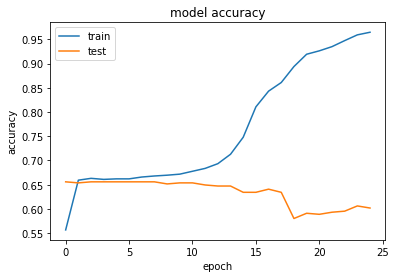

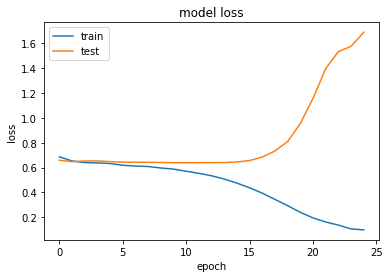

In [38]:
history = model.fit(x_train, y_softmax_train, validation_data=(x_val, y_softmax_val), epochs=25, batch_size=1024,shuffle=True, callbacks=[checkpoint])
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save('lstm_w2v.h5')

### Explanation using LIME

For one example

In [39]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

from lime import lime_tabular

In [40]:
y_pred = np.argmax(model.predict(x_val), axis=1)
y_true = y_val
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.77      0.72       303
         1.0       0.39      0.28      0.33       159

    accuracy                           0.60       462
   macro avg       0.53      0.53      0.52       462
weighted avg       0.58      0.60      0.58       462



In [41]:
from lime.lime_text import LimeTextExplainer

In [42]:
explainer = LimeTextExplainer(class_names=["NoToxic","Toxic"])

In [43]:
def new_predict_working(x):
    if not isinstance(x, list): 
        x = [x]
    data_temp = np.zeros((len(x), MAX_WORD_NUM), dtype='int32')
    for i, sentence in enumerate(x):
        words = sentence.split(" ")
        for k, word in enumerate(words):
            try:
                if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                    data_temp[i,k] = tokenizer.word_index[word]
            except:
                pass
    return model.predict(data_temp)

In [44]:
def vectorize(x):
    if not isinstance(x, list): 
        x = [x]
    data_temp = np.zeros((len(x), MAX_WORD_NUM), dtype='int32')
    for i, sentence in enumerate(x):
        words = sentence.split(" ")
        for k, word in enumerate(words):
            try:
                if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                    data_temp[i,k] = tokenizer.word_index[word]
            except:
                pass
    return data_temp

In [45]:
string = ' '.join([str(elem) for elem in sentences[2]]) 

For all samples

In [46]:
class Transform():
    def __init__(self):
        print("")
    
    def fit(self, X, y = None):
        print("")
        return self
    
    def transform(self, X, y =None):
        X_ = vectorize(X)
        return X_
    

In [219]:
t = Transform()

In [220]:
from sklearn.pipeline import make_pipeline
c = make_pipeline(Transform(),model)

In [221]:
exp = explainer.explain_instance(string,c.predict_proba, num_features=6, top_labels = 2)

In [282]:
def getPredictedWordsFromSentence(sentence, threshold):
    print(sentence)
    y_pred = new_predict_working([sentence])
    if np.argmax(y_pred) == 1 :
        predicted_words = []
        exp = explainer.explain_instance(sentence,c.predict_proba, num_features=6, top_labels = 2)
        expWords = exp.as_list()
        maxScore = max(expWords, key = lambda i : i[1])[0]
        expWords = filter(lambda t: t[1] > threshold, expWords )
        wordsList = [i[0] for i in expWords]
        wordsList.append(maxScore) if maxScore not in wordsList else wordsList
        return wordsList
    else : return []

In [283]:
getPredictedWordsFromSentence(string, 0.25)

stop protecting idiots let nature add bleach gene pool


['protecting']

10
10


[5, 6, 7, 8, 9, 10, 11, 12, 13, 14]